In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import imblearn
import mlxtend
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix

#from imblearn.combine import SMOTETomek

df = pd.read_csv("C:/Users/owcha/Desktop/application_train.csv")


In [43]:
#Rendu compte de nombreuses données manquantes entrée 28 et 44.
df = df.dropna(axis=0)

In [44]:
print('Datashape: ', df.shape)

#On ne peut traiter des données de type str.
#Récuperation des colonnes de type pd object.
le = LabelEncoder()
le_count = 0

useless_cat = [ col for col in df if len(list(df[col].unique())) == 1 ]
for cat in useless_cat:
    df = df.drop(cat, axis=1)


# Iterate through the columns
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) >= 2:
            df[col] = le.fit_transform(df[col])
            le_count += 1
            
print('%d columns were label encoded.' % le_count)
print('%d columns were removed.' % len(useless_cat)) #On optimise en balle.

print('Datashape: ', df.shape)

Datashape:  (8602, 122)
15 columns were label encoded.
4 columns were removed.
Datashape:  (8602, 118)


In [45]:
print('Datashape: ', df.shape)
df.head()

Datashape:  (8602, 118)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
71,100083,0,0,1,1,0,103500.0,573628.5,24435.0,463500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
124,100145,0,0,0,1,1,202500.0,260725.5,16789.5,198000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
152,100179,0,0,0,0,0,202500.0,675000.0,53329.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
161,100190,0,0,1,0,0,162000.0,263686.5,24781.5,238500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
255,100295,1,0,1,0,1,225000.0,1019205.0,31032.0,774000.0,...,1,0,0,0,0.0,0.0,0.0,6.0,0.0,1.0


In [46]:
#Besoin de split notre dataset car cross validation->def de cross validation.

dfTrain = df.iloc[:round(df.shape[0] * 0.9),:] #90%
dfRow = df.iloc[round(df.shape[0] * 0.9):,:]  
dfTest = dfRow.iloc[:(dfRow.shape[0]-5),:]
dfKeep = dfRow.iloc[(dfRow.shape[0]-5):,:]

print('dfTrain: ',dfTrain.shape)
print('dfTest: ',dfTest.shape)
print('dfKeep: ',dfKeep.shape)

dfTrain:  (7742, 118)
dfTest:  (855, 118)
dfKeep:  (5, 118)


0    0.938646
1    0.061354
Name: TARGET, dtype: float64


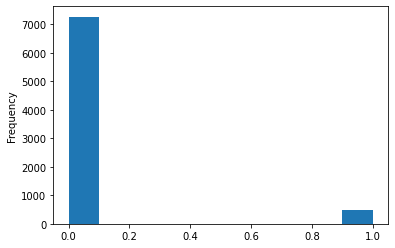

In [47]:
#On regarde la sortie
print( pd.value_counts(dfTrain['TARGET'], normalize=True) )

dfTrain['TARGET'].astype(int).plot.hist();

dfTrain:  (7267, 118)
dfTrain:  (475, 118)
Training data shape:  (14380, 118)


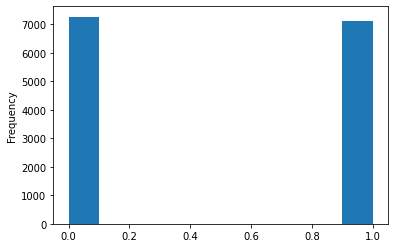

In [48]:
#Oversampling car jeu de données réduit

# Separate majority and minority classes
df_majority = dfTrain[dfTrain['TARGET']==0]
df_minority = dfTrain[dfTrain['TARGET']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=round(dfTrain.shape[0] * 0.918744),  # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
dfTrainUpsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
dfTrainUpsampled['TARGET'].value_counts()
print('Training data shape: ', dfTrainUpsampled.shape)

dfTrainUpsampled['TARGET'].astype(int).plot.hist();

In [49]:
#Traitement des données manquantes.
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(dfTrainUpsampled)

Your selected dataframe has 118 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [50]:
def missing_values_by_row(df):
    count = 0
    for index, row in df.iterrows():
        for prop in row:
            if not prop:
                count += 1
                break;
                
    print(count) 
    
missing_values_by_row(dfKeep)

5


In [51]:
print( dfTrainUpsampled.dtypes.value_counts() )
            

float64    65
int64      38
int32      15
dtype: int64


In [70]:
#Mise en place du premier knn.
#Séparation des X et des y.

X_train = dfTrainUpsampled.drop('TARGET', 1)
y_train = dfTrainUpsampled['TARGET']

X_test = dfTest.drop('TARGET', 1)
y_test = dfTest['TARGET']

#Déclaration du knn1.
knn1 = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn1.fit(X_train, y_train)

#Première prédiction
y_pred1 = knn1.predict(X_test)

0.8818713450292398


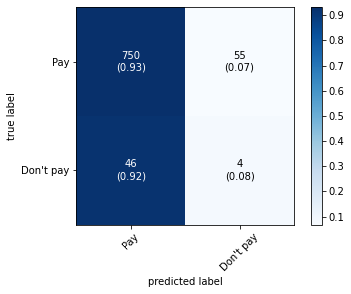

In [71]:
conf_mat = confusion_matrix(y_test, y_pred1)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=["Pay", "Don't pay"])

print ( conf_mat.diagonal().sum()/conf_mat.sum() )

Text(0, 0.5, 'Error Rate')

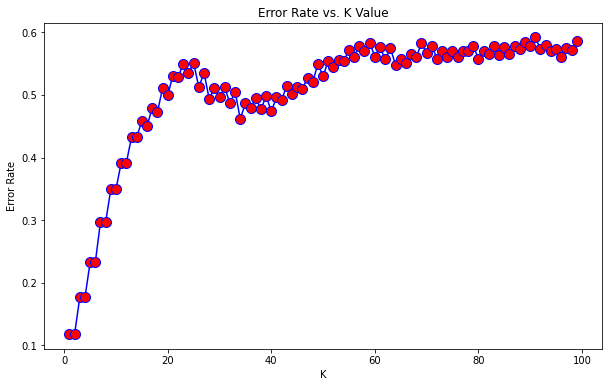

In [62]:
error_rate = []

# Will take some time
for i in range(1,100):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
    
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='solid', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')